<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Libraries" data-toc-modified-id="Libraries-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Target-labels" data-toc-modified-id="Target-labels-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Target labels</a></span></li><li><span><a href="#Input-text" data-toc-modified-id="Input-text-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Input text</a></span></li></ul></li><li><span><a href="#Train-and-test-splits" data-toc-modified-id="Train-and-test-splits-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train and test splits</a></span></li><li><span><a href="#Models" data-toc-modified-id="Models-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#Random-Classifier" data-toc-modified-id="Random-Classifier-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Random Classifier</a></span></li><li><span><a href="#Most-Frequent-Classifier" data-toc-modified-id="Most-Frequent-Classifier-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Most Frequent Classifier</a></span></li><li><span><a href="#Multilingual-BERT" data-toc-modified-id="Multilingual-BERT-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Multilingual BERT</a></span></li></ul></li></ul></div>

# Introduction

This notebook contains my submission for Media Prima Digital's Data Science Assesment.

# Setup

In [1]:
%matplotlib inline

Navigate to the project's root directory:

In [2]:
%%capture
%cd ..

# Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import src.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

# Data

Load the data:

In [4]:
df = pd.read_excel('~/mpd_data/MPD data science assessment NLP v1.1.xlsx',
                    sheet_name='nstp_articles_sample',
                    keep_default_na=False)

In [5]:
df.describe()

,title,body,pub,sect,subsect
count,1428,1428,1428,1428,1428
unique,1361,1405,3,27,46
top,Keputusan Liga Perdana Inggeris,© New Straits Times Press (M) Bhd\n\n,bh,berita,
freq,4,3,569,297,536


Create input and target columns:

In [6]:
df['text'] = df['title'].str.cat(df['body'], sep=' ').str.replace('\n', ' ')
df.head()

,title,body,pub,sect,subsect,text
0,Iran warns protesters will &#039;pay the price...,TEHRAN: Iran warned on Sunday that protesters ...,nst,world,,Iran warns protesters will &#039;pay the price...
1,"Tiga minit, RM1.5 juta",[kalidevi@hmetro.com.my](mailto:kalidevi@hmetr...,hm,mutakhir,,"Tiga minit, RM1.5 juta [kalidevi@hmetro.com.my..."
2,Tiada tol di Lebuhraya Persekutuan selepas 24 ...,[norrasyidah@bh.com.my](mailto:norrasyidah@bh....,bh,berita,nasional,Tiada tol di Lebuhraya Persekutuan selepas 24 ...
3,Pogba urges misfiring Man Utd to &#039;wake up...,LONDON: Paul Pogba has called on Manchester Un...,nst,sports,football,Pogba urges misfiring Man Utd to &#039;wake up...
4,Hundreds of Indonesian couples ring in the new...,JAKARTA: Hundreds of Indonesian couples celebr...,nst,world,,Hundreds of Indonesian couples ring in the new...


In [7]:
def create_target(rows):
    sect, subsect = rows
    return subsect if subsect else sect

df['target'] = df[['sect', 'subsect']].apply(create_target, axis=1)
df.head()

,title,body,pub,sect,subsect,text,target
0,Iran warns protesters will &#039;pay the price...,TEHRAN: Iran warned on Sunday that protesters ...,nst,world,,Iran warns protesters will &#039;pay the price...,world
1,"Tiga minit, RM1.5 juta",[kalidevi@hmetro.com.my](mailto:kalidevi@hmetr...,hm,mutakhir,,"Tiga minit, RM1.5 juta [kalidevi@hmetro.com.my...",mutakhir
2,Tiada tol di Lebuhraya Persekutuan selepas 24 ...,[norrasyidah@bh.com.my](mailto:norrasyidah@bh....,bh,berita,nasional,Tiada tol di Lebuhraya Persekutuan selepas 24 ...,nasional
3,Pogba urges misfiring Man Utd to &#039;wake up...,LONDON: Paul Pogba has called on Manchester Un...,nst,sports,football,Pogba urges misfiring Man Utd to &#039;wake up...,football
4,Hundreds of Indonesian couples ring in the new...,JAKARTA: Hundreds of Indonesian couples celebr...,nst,world,,Hundreds of Indonesian couples ring in the new...,world


I assume that the goal is to classify `text` according to `target`.

# EDA

## Target labels

View distribution of target labels:

In [8]:
labels_df = df\
    .groupby('target')\
    .size()\
    .to_frame('count')\
    .sort_values('count', ascending=False)

labels_df['count'].quantile([0, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99, 1])

0.00      1.0
0.25      3.0
0.50     12.0
0.75     30.0
0.90     74.2
0.95     96.1
0.99    134.0
1.00    134.0
Name: count, dtype: float64

Replace targets with count less 10 with 'unknown' class:

In [9]:
minority_labels = labels_df.query('count < 10').reset_index()['target'].tolist()

df['target'] = df['target'].where(~df['target'].isin(minority_labels), 'unknown')

## Input text

View distribution of `text` lengths:

In [10]:
df['text_len'] = df['text'].str.split(' ').apply(lambda r: len(r))

df['text_len'].quantile([0, 0.25, 0.5, 0.75, 0.90, 0.95, 1])

0.00      10.00
0.25     205.00
0.50     278.00
0.75     367.25
0.90     512.30
0.95     673.00
1.00    3160.00
Name: text_len, dtype: float64

How many articles exceed 512 words?

In [11]:
n, _ = df.query('text_len > 512').shape
print(f'There are {n} articles with more than 512 words')

There are 143 articles with more than 512 words


# Train and test splits

In [12]:
input_df = df[['text', 'pub', 'target']]

Recode `target` column:

In [13]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(input_df['target'])

print('class\tlabel')
for idx, label in enumerate(label_encoder.classes_):
    print(f'{idx}\t{label}')

class	label
0	amerika
1	arena
2	asia
3	bisnes
4	bola
5	business
6	columnists
7	crime-courts
8	football
9	global
10	groove
11	hati
12	kes
13	korporat
14	lain-lain
15	mutakhir
16	nasional
17	nation
18	nuansa
19	others
20	pasaran
21	pendidikan
22	politics
23	politik
24	raket
25	rap
26	selebriti
27	setempat
28	unknown
29	utama
30	wilayah
31	world


In [14]:
input_df.loc[:, 'target'] = label_encoder.transform(input_df['target'])

/home/ec2-user/anaconda3/envs/mpd/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [15]:
X_train, X_dev, Y_train, Y_dev = train_test_split(input_df[['text', 'pub']],
                                                  input_df['target'],
                                                  test_size=0.3,
                                                  random_state=123, 
                                                  shuffle=True,
                                                  stratify=input_df['target'])

In [16]:
train_df = pd.concat([X_train, Y_train], axis=1)
dev_df = pd.concat([X_dev, Y_dev], axis=1)

In [17]:
train_df.to_csv('~/mpd_data/train.tsv', header=True, index=False, sep='\t')
dev_df.to_csv('~/mpd_data/dev.tsv', header=True, index=False, sep='\t')

# Model Development

## Random Classifier (Baseline 1)

In [18]:
np.random.seed(123)
y_random = np.random.choice(label_encoder.classes_, Y_dev.size, )
y_random = label_encoder.transform(y_random)

random_df = dev_df.copy()
random_df['pred'] = y_random
metrics_random_classifier = metrics.compute_eval_metrics(random_df)

/home/ec2-user/anaconda3/envs/mpd/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [19]:
metrics.print_metrics(metrics_random_classifier)

Overall accuracy:     0.0350
Overall f1-macro:     0.0344

BM accuracy:          0.0375
BM f1-macro:          0.0311

EN accuracy:          0.0294
EN f1-macro:          0.0131



## Most Frequent Class Classifier (Baseline 2)

In [20]:
most_freq_class = Y_train\
                    .to_frame()\
                    .groupby('target')\
                    .size()\
                    .sort_values(ascending=False)[0]

most_freq_df = dev_df.copy()
most_freq_df['pred'] = most_freq_class
metrics_most_freq_classifier = metrics.compute_eval_metrics(most_freq_df)

/home/ec2-user/anaconda3/envs/mpd/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
metrics.print_metrics(metrics_most_freq_classifier)

Overall accuracy:     0.0932
Overall f1-macro:     0.0053

BM accuracy:          0.1365
BM f1-macro:          0.0104

EN accuracy:          0.0000
EN f1-macro:          0.0000



## Multilingual BERT

Note: Click [here](https://arxiv.org/pdf/1810.04805.pdf) for model details.

In [22]:
!source activate mpd; python  src/train.py --data_dir ~/mpd_data \
                                           --output_dir ~/mpd_output \
                                           --num_classes 32 \
                                           --learning_rate 2e-5 \
                                           --num_train_epochs 20

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2019-02-15 17:14:05.807206: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-02-15 17:14:05.933238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-02-15 17:14:05.933691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:1e.0
totalMemory: 15.78GiB freeMemory: 15.37GiB
2019-02-15 17:14:05.933718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2019-02-15 17:14:06.358464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Dev

INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: None
INFO:tensorflow:tokens: [CLS] Le ##pas ##kan 100 tem ##bakan LE ##LA ##KI yang men ##emba ##k mati tim ##bala ##n she ##riff dan men ##cede ##rak ##an empat lagi anggota polis , me ##le ##pas ##kan kira - kira 100 tem ##bakan ketika melakukan [UNK] serangan hen ##da ##p [UNK] di sebuah bangunan apart ##men di Denver ialah bekas tentera Amerika Syarikat yang pernah be ##rp ##erang di Iraq . Menurut Daily Mail , lelaki itu , Matthew R ##ie ##hl , 37 , men ##yia ##rkan video di YouTube awal bulan lalu , menyatakan mah ##u mere ##but ja ##watan Sheriff tempatan . R ##ie ##hl dite ##mba ##k mati oleh polis . Reuters me ##lap ##or ##kan , menurut ken ##yat ##aan Pe ##jabat Sheriff Daerah Douglas , lelaki itu men ##emba ##k mati tim ##bala ##n Sheriff Zack ##ari Par ##rish , 29 , dan men ##cede ##rak ##an empat anggota polis serta dua orang awam . Sheriff Tony Spur ##lock berkata , belum dapat di ##pas ##tikan pun ##ca serangan dan be

INFO:tensorflow:guid: None
INFO:tensorflow:tokens: [CLS] Dua sungai me ##le ##pasi paras amar ##an [ b ##hne ##ws @ b ##h . com . my ] ( mail ##to : b ##hne ##ws @ b ##h . com . my ) K ##U ##AN ##TA ##N : Dua sungai di negeri ini , Sungai Tem ##beli ##ng di Kuala Ta ##han , Je ##rant ##ut dan Sungai Bela ##t di Sri Dama ##i di sini , me ##le ##pasi tahap jin ##gga atau amar ##an yang men ##ded ##ahkan kawasan rendah , dili ##mpa ##hi air sungai . Be ##rdas ##arkan ru ##jukan pada lama ##n web info ##ban ##jir . water . gov . my sehingga jam 10 pagi , paras Sungai Tem ##beli ##ng me ##le ##pasi tahap amar ##an , iaitu 66 . 10 meter ( 68 . 00 meter bagi paras ba ##haya ) , manakala Sungai Bela ##t sebanyak 4 . 21 meter ( 5 . 00 meter bagi paras ba ##haya ) . Selain itu , ba ##ca ##an air Sungai Ku ##anta ##n di Pasir Ke ##mu ##di di sini menunjukkan melebihi paras was ##pada atau kuning iaitu 5 . 48 meter ( 6 . 40 meter bagi paras was ##pada ) . Pen ##ingkatan paras air itu be ##rp ##un 

# Model Evaluation

The Multilingual BERT model outperforms the two baseline models by a wide margin in terms of accuracy and f1-macro score at the aggregate level (considering both Malay and English articles simultaneously ) and at the langugage level (considering Malay and English articles separately).

Examining the common errors this model makes reveals the following:

In [23]:
mb_results_df = pd.read_csv('~/mpd_output/eval_results.tsv', sep='\t')
eval_metrics = metrics.compute_eval_metrics(mb_results_df)

Confusion matrix, without normalization
[[ 5  0  1 ...  0  0  0]
 [ 0 26  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  9  0]
 [ 0  0  0 ...  0  0 21]]


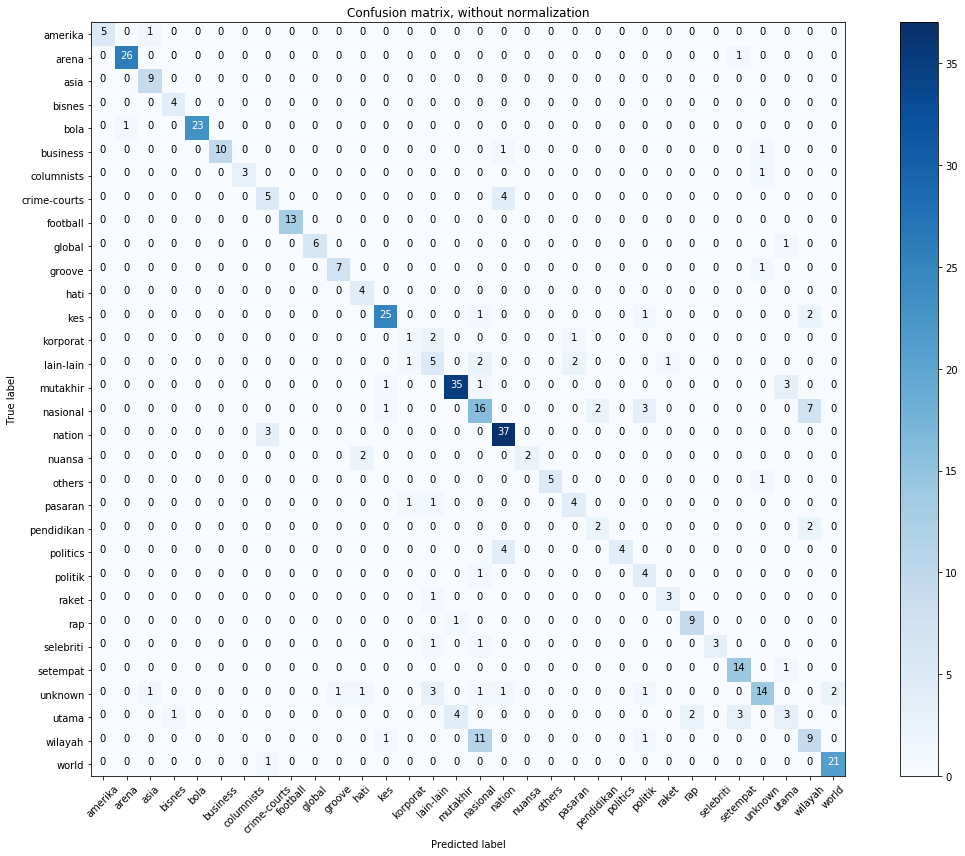

In [24]:
plt.figure(figsize=(6.4*2.5, 4.8*2.5))
metrics.plot_confusion_matrix(eval_metrics['overall']['confusion_matrix'], classes=label_encoder.classes_,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.83 0.   0.17 ... 0.   0.   0.  ]
 [0.   0.96 0.   ... 0.   0.   0.  ]
 [0.   0.   1.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.23 0.   0.  ]
 [0.   0.   0.   ... 0.   0.41 0.  ]
 [0.   0.   0.   ... 0.   0.   0.95]]


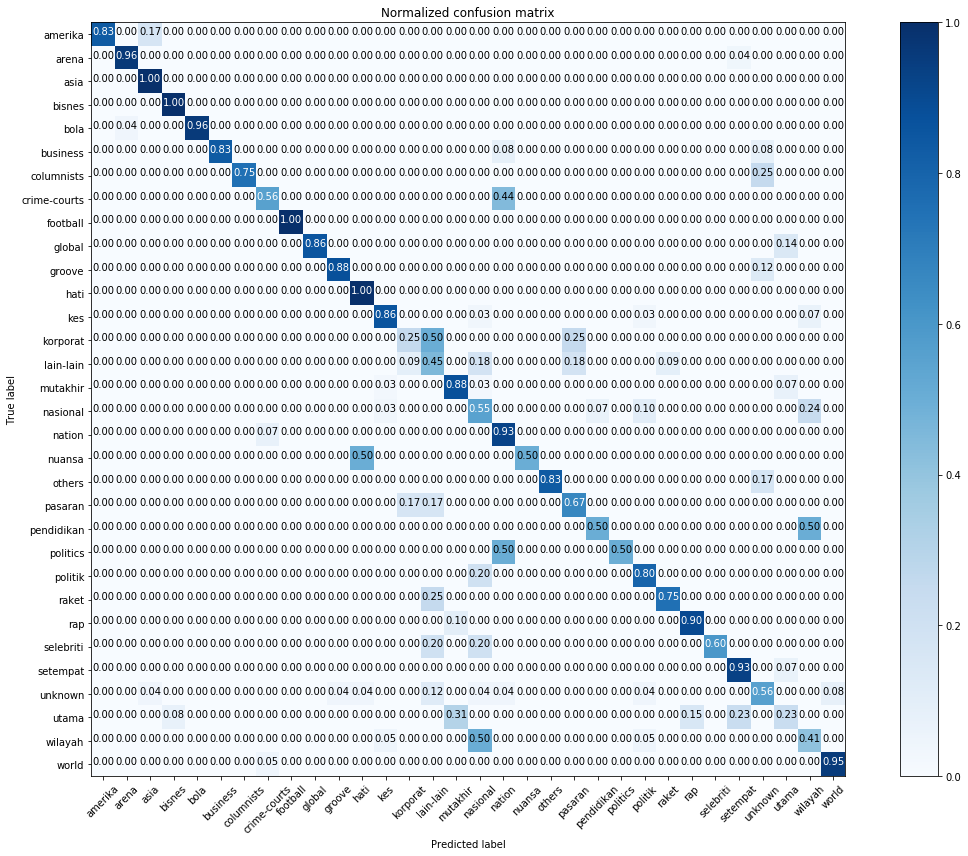

In [25]:
np.set_printoptions(precision=2)
plt.figure(figsize=(6.4*2.5, 4.8*2.5))
metrics.plot_confusion_matrix(eval_metrics['overall']['confusion_matrix'], classes=label_encoder.classes_, normalize=True,
                      title='Normalized confusion matrix')

In [26]:
mb_results_df['target'] = label_encoder.inverse_transform(mb_results_df['target'])
mb_results_df['pred'] = label_encoder.inverse_transform(mb_results_df['pred'])

In [27]:
errors_df = mb_results_df.query('(target=="wilayah" | target=="nasional") and target!=pred ')
errors_df

,text,pub,target,pred,lang
0,Periksa semua struktur kemudahan awam: MB Tere...,bh,wilayah,nasional,bm
4,Dua sungai melepasi paras amaran [bhnews@bh.co...,bh,wilayah,nasional,bm
14,Tiket feri kembali harga asal [bhnews@bh.com.m...,bh,wilayah,nasional,bm
63,&#039;Jangan terpengaruh khabar angin WhatsApp...,bh,nasional,wilayah,bm
69,Polis kenal pasti 4 mangsa maut [bhnews@bh.com...,bh,nasional,kes,bm
72,UMNO Putatan perlu mantapkan jentera pilihan r...,bh,wilayah,politik,bm
117,"Banjir di Kelantan pulih, semua pusat pemindah...",bh,nasional,wilayah,bm
123,&#039;Hari pertama ke sekolah tanpa mama dan p...,bh,nasional,pendidikan,bm
135,Albino bukan penghalang kejayaan [poliana@bh.c...,bh,wilayah,nasional,bm
137,SMO dapat sambutan majikan [suhaila.shahrul@bh...,bh,nasional,wilayah,bm


In [28]:
print('Article 425:')
print(errors_df.loc[425].text)

Article 425:
RM25 juta bina benteng hakisan [kandau@bh.com.my](mailto:kandau@bh.com.my)    MIRI: Kerajaan Pusat memperuntukkan RM25 juta bagi menampung kos pembinaan benteng hakisan di Jalan Kuala Baram Lama, di sini supaya kawasan penempatan itu selamat daripada bencana ombak dan fenomena air pasang besar.  Projek berkonsepkan benteng hakisan pantai seperti diperkenalkan di Terengganu itu dijadualkan bermula Jun tahun ini dan dijangka siap dalam tempoh tiga tahun.  Menteri Sumber Asli dan Alam Sekitar, Datuk Seri Junaidi Tuanku Wan Jaafar, berkata peruntukan itu juga turut membabitkan kos menaiktaraf kemudahan berkaitan, khusus bagi memudahkan kehidupan komuniti nelayan di kawasan terbabit.  "Peruntukan sama juga bagi menampung projek pengindahan kawasan Kampung Batu Satu supaya menjadi tarikan pelancongan," katanya selepas meninjau lokasi pembinaan benteng hakisan itu di Kampung Batu Satu, di sini.  Beliau berkata, projek itu akan dilaksanakan pihak Jabatan Pengairan dan Saliran mene

In [29]:
print('Article 0:')
print(errors_df.loc[0].text)

Article 0:
Periksa semua struktur kemudahan awam: MB Terengganu [bhkt@bh.com.my](mailto:bhkt@bh.com.my)    KUALA NERUS: Kerajaan negeri mengarahkan Majlis Bandaraya Kuala Terengganu (MBKT) memeriksa semua struktur bangunan dan kemudahan awam di bandar raya ini, susulan insiden bumbung laluan pejalan kaki di Jalan Daik, di sini, runtuh, malam tadi.  Menteri Besar, Datuk Seri Ahmad Razif Abd Rahman, berkata penelitian terperinci perlu dibuat bagi memastikan semua kemudahan disediakan berada dalam keadaan selamat, kukuh dan tidak membahayakan pengguna, terutama ketika musim tengkujuh kini.  "Kita sedang menunggu laporan lengkap daripada MBKT bagi mengenal pasti punca berlakunya masalah itu.  "Sebaik puncanya dikenal pasti, kita akan lakukan tindakan seterusnya sama ada ia disebabkan oleh reka bentuk yang tidak sesuai, kecuaian manusia atau bencana akibat angin kuat malam tadi," katanya selepas mengadakan lawatan di Sekolah Kebangsaan (SK) Tok Jembal (SK T&apost;jemS) di sini, hari ini.  B

In [30]:
print('Article 406:')
print(errors_df.loc[406].text)

Article 406:
Murid OKU bersemangat hadir ke sekolah [bhnews@bh.com.my](mailto:bhnews@bh.com.my)    KUANTAN: Keterujaan dan semangat untuk memulakan sesi persekolahan tahun satu turut dirasai murid berstatus orang kelainan upaya (OKU), Muhammad Aiman Syazrin Abdullah, 7, yang hadir ke Sekolah Kebangsaan (LKTP) Bukit Goh, dekat sini, hari ini.  Muhammad Aiman yang menghidap masalah Celebral Palsy sejak kecil mengakui teruja dan berasa seronok dapat hadir ke sekolah seperti murid lain.  "Saya bangun awal untuk bersiap ke sekolah... rasa seronok sebab dapat berjumpa kawan-kawan baru.  "Saya mahu belajar bersungguh-sungguh dan mahu jadi seorang yang berjaya dalam pelajaran... selain itu, saya juga sangat minat sukan bola sepak, kalau boleh saya nak jadi seorang pemain bola sepak satu hari nanti," katanya yang meminati bintang bola sepak terkenal dari kelab Real Madrid, Cristiano Ronaldo.  Sementara itu, Guru Kelas Program Pendidikan Khas Integrasi (PPKI), Norhaliza Razali berkata, murid aka

The above analysis shows that the model tends to get confused by `wilayah` and `nasional` articles. This can be explained by:

1. **Ambiguous labels** It is not immediately clear the criteria used to label an article as `wilayah` and `nasional`. For instance, article 425 is about how the federal government is helping Miri so the label `wilayah` makes sense. However, article 0 is entirely about Terengganu and has no mention of the federal government at all. Yet, it is classified as `wilayah`. In these situations, the model will occasionally mistake `wilayah` for `nasional` and vice versa. 
2. **Label granularity** Article 406 is labeled as `nasional` but was classified as `pendidikan`. The content is about OKU students at primary schools. While their experience attending primary one education may be of national interest, classifying it as education is certainly not wrong too. It appears the model prefers labels that are more specific to the content. 

We can consider the following course of actions to improve the model's performance:

1. **Treat this problem as multi-label classificatoin** Since an article can cover multiple topics e.g. the Education Miniter discussing the country's education blueprint can most certainly be classified as both `nasional` and `education`, it makes sense to rephrase this problme in terms of multi-label classification.

2. **Language specific models** English is a high-resource langauge so the performance of this model can definitely be improved by using a model pre-trained solely on an English-only corpus.

3. **Hyperparameter tuning** Fine-tuning the model on a different set of hyperameters may improve its performance.

# Model Serving

Multilingual BERT is written in TensorFlow so you can export the weights to serve it on TensorFlow Serving. Click [here](https://www.tensorflow.org/serving) for more details.